<img style="float: left;padding: 1.3em" src="https://indico.phys.sinica.edu.tw/event/74/attachments/246/623/KIW-10.png" width="50%">  

#  Gravitational Open Data Workshop @KIW10


#### Tutorial 1.1: Discovering open data from GW observatories

This notebook describes how to discover what data are available from the [Gravitational-Wave Open Science Center (GWOSC)](https://gwosc.org/).

Please upload the tutorial resources from [github](https://github.com/KAGRA-TW-ML/2023-GW-Workshops-in-Taiwan), and upload it to your google storage. Then get into the folder you put the tutorial notebook (.ipynb files), and please open it with "google colaboratory". 



## Check out your current environment and download the data

Please try to download the dataset H-H1_LOSC_4_V1-815411200-4096.hdf5 ((S5, began in November 2005) following the class instructions or from the [link](https://drive.google.com/file/d/1sLyXa8H3Jdc0IpS-a9juV0IOeWZ5zm_K/view?usp=share_link). Please upload this file to google colud in the same folder with your tutorial notebook (.ipynb file). 

Now let us set uo the environment of google cloud and check the path of the files.


In [16]:
#----------------------
# Setting up the environment
#----------------------
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/2023-GW-Workshops-in-Taiwan-main/Day1
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/2023-GW-Workshops-in-Taiwan-main/Day1
'Discovering Data.ipynb'	      __pycache__
 H-H1_LOSC_4_V1-815411200-4096.hdf5   readligo.py


## What's in LIGO data file? 

dataFile is an object which can be treated as a Python dictionary, and contains all of the information from the data file.

H-H1_LOSC_4_V1-815411200-4096.hdf5 is Hanford dataset downloaded from the fifth science run (S5,began in November 2005) with sampling rate of 4K.

In [17]:
#----------------------
# Import needed modules
#----------------------
import numpy as np
import matplotlib.pyplot as plt
import h5py

#-------------------------
# Open the File
#-------------------------
fileName = '/content/drive/MyDrive/H-H1_LOSC_4_V1-815411200-4096.hdf5'
dataFile = h5py.File(fileName, 'r')

#----------------------
# Explore the file
#----------------------
for key in dataFile.keys():
    print(key) 

meta
quality
strain


 This gives a high level picture of what's contained in a LIGO data file. There are 3 types of information:


*   meta: Meta-data for the file. This is basic information such as the GPS times covered, which instrument, etc.
*   quality: Refers to data quality. The main item here is a 1 Hz time series describing the data quality for each second of data. This is an important topic, and we'll devote a whole step of the tutorial to working with data quality information.
*   strain: Strain data from the interferometer. In some sense, this is "the data", the main measurement performed by LIGO.



##Plot a time series

Let's continue adding to plot_strain.py to make a plot of a few seconds of LIGO data. To store the strain data in a convienient place, add these lines to plot_strain.py 

In [18]:
#---------------------
# Read in strain data
#---------------------
strain = dataFile['strain']['Strain'][()]
ts = dataFile['strain']['Strain'].attrs['Xspacing']

#-----------------------
# Print out some meta data
#-----------------------
metaKeys = dataFile['meta'].keys()
meta = dataFile['meta']
for key in metaKeys:
    print(key, meta[key][()])

#---------------------------
# Create a time vector
#---------------------------
gpsStart = meta['GPSstart'][()]
duration = meta['Duration'][()]
gpsEnd   = gpsStart + duration
time = np.arange(gpsStart, gpsEnd, ts)

Description b'Strain data time series from LIGO'
DescriptionURL b'http://losc.ligo.org/'
Detector b'H1'
Duration 4096
GPSstart 815411200
Observatory b'H'
Type b'StrainTimeSeries'
UTCstart b'2005-11-07T15:06:27'


The code above accesses the 'Strain' data object that lives inside the group 'strain'. The "attribute" 'Xspacing' tells how much time there is between each sample, and we store this as ts. The "value" (i.e, [()]) of the data object contains the strain value at each sample - we store this as strain.  
Let's use the meta-data to make a vector that will label the time stamp of each sample. In the same way that we indexed dataFile as a Python dictionary, we can also index dataFile['meta'].

Now you should see that the GPS start time and the duration are both stored as meta-data. To calculate how much time passes between samples, we can divide the total duration by the number of samples:

 The numpy command arange creates an array (think a column of numbers) that starts at gpsStart, ends at gpsEnd (non-inclusive), and has an increment of ts between each element.

Finally, let's use all of this to plot a few seconds worth of data. Since this data is sampled at 4096 Hz, 10,000 samples corresponds to about 2.4 s. 

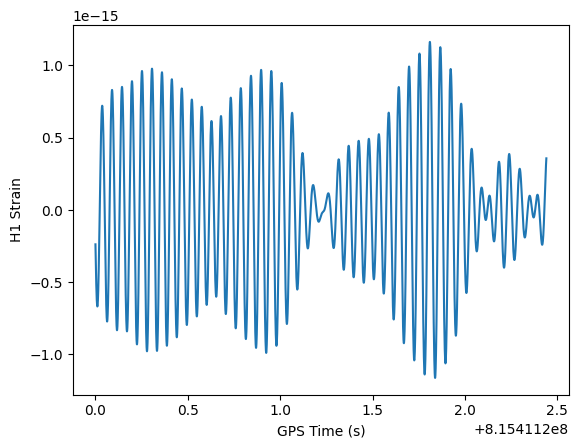

In [19]:
#----------------------
# Plot the time series
#----------------------
numSamples = 10000
plt.plot(time[0:numSamples], strain[0:numSamples])
plt.xlabel('GPS Time (s)')
plt.ylabel('H1 Strain')
plt.show()

The last command, plt.show(), may not be necessary if you are working in the matplotlib interactive mode. 

You may be surprised that the data looks smooth and curvy, rather than jagged and jumpy as you might expect for white noise.

That's because white noise has roughly equal power at all frequencies, which LIGO data does not. Rather, LIGO data includes noise that is a strong function of frequency - we often say the noise is "colored" to distinguish it from white noise. The wiggles you see in the plot above are at the low end of the LIGO band (around 20 Hz). In general, LIGO noise is dominated by these low frequencies. 

## Handling data in the time domain

In reality, we do not need to get back the data and everything can be easily work with an  object-oriented programming (OOP).
[GWpy](https://gwpy.github.io/docs/stable/index.html) is heavily object-oriented, meaning almost all of the code you run using GWpy is based around an object of some type, e.g. `TimeSeries`.
Most of the methods (functions) we will use are attached to an object, rather than standing alone, meaning you should have a pretty good idea of what sort of data you are dealing with (without having to read the documentation!).

For a quick overview of object-oriented programming in Python, see [this blog post by Jeff Knupp](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/).

Let us install gwpy online at first!!

In [20]:
# -- Uncomment following line if running in Google Colab
! pip install -q 'gwpy==3.0.4'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


##Finding open data

segment = (815411200, 815411203) has 3*4096 samples.

We can use the TimeSeries.fetch_open_data method to download data directly from https://www.gw-openscience.org, but we need to know the GPS times. We can query for the GPS time of an event as follows and obtain a similar plot:

Fetched 1 URLs from gwosc.org for [815411200 .. 815411203))
Reading data... [Done]


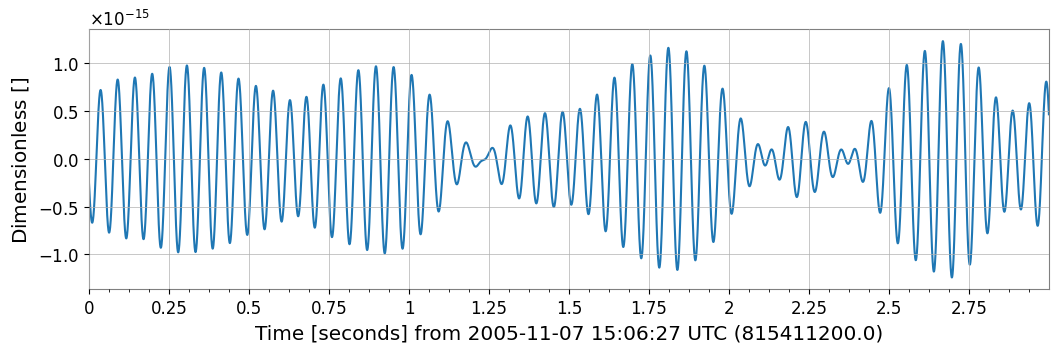

In [21]:
segment = (815411200, 815411203)
          
from gwpy.timeseries import TimeSeries
hdata = TimeSeries.fetch_open_data('H1', *segment, verbose=True)

%matplotlib inline
plot = hdata.plot()

## Load one data file through API

More details about gwpy will be introduced later. Let us stop here.
An alternative way to load the data is through the example API (Application Programming Interface), [readligo.py](https://gwosc.org/static/sample_code/readligo.py), and place it in the same directory with your GWOSC data. In addition to reading HDF5 files, the example API will also read gravitational wave frame files, like those described on the [frame library page](https://gwosc.org/lsc_software). 

In [22]:
!pwd

/content/drive/MyDrive/2023-GW-Workshops-in-Taiwan-main/Day1


In [23]:
import sys
sys.path.append('/content/drive/MyDrive/2023-GW-Workshops-in-Taiwan-main/Day1')


import numpy as np
import readligo as rl
#----------------------------------------------------------------
# Load all GWOSC data from a single file 
#----------------------------------------------------------------
strain, time, chan_dict = rl.loaddata(
                          'H-H1_LOSC_4_V1-815411200-4096.hdf5', 'H1')

The function loaddata() returns the strain time series, the gps time of each sample, and a dictionary of all of the data quality flags in the file. As in the last step of this tutorial, each data quality channel in chan_dict is stored as a 1 Hz time series.

GWOSC data files contain gaps where strain data is not available - the DATA flag is a 1 at times with strain data. To loop over strain segments which contain usable DATA: 

In [24]:
slice_list = rl.dq_channel_to_seglist(chan_dict['DATA'])
for slice in slice_list:
    time_seg = time[slice]
    strain_seg = strain[slice]
    # -- Do stuff with strain segment here

#Load data using a segment list

Once the data files and readligo.py are in your working directory, the API will make it easy to construct segment lists and load data on demand.

First, let's construct a segment list representing data that passes the CBC Low Mass category 2 data quality flag: 

Typing "print(segList)" will show the GPS times of Science Mode times for this data. You can get the same information by requesting segment lists from the Timeline Query Forms.

As an example of how to use segment lists to load only Science Mode data, we can plot the first few seconds of each segment 

Using data directory . ...
SegmentList( [(815411200, 815411205)] )
Using data directory . ...
Loading ./H-H1_LOSC_4_V1-815411200-4096.hdf5


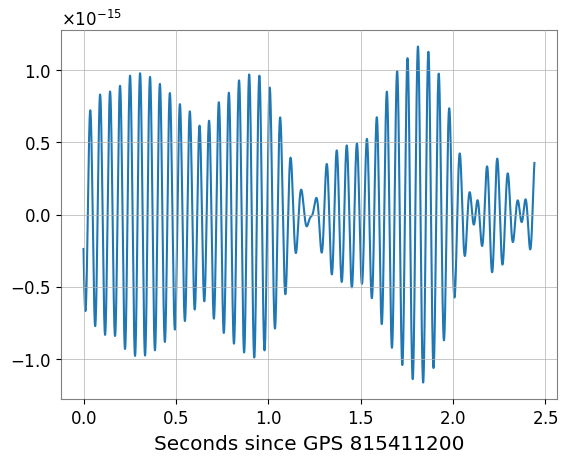

In [25]:
start = 815411200
stop =  815411205
segList = rl.getsegs(start, stop, 'H1', flag='CBCLOW_CAT2')
print(segList)
#-------------------------------------------
# Plot a few seconds of each "good" segment
#-------------------------------------------
N = 10000
for (begin, end) in segList:
    # -- Use the getstrain() method to load the data
    strain, meta, dq = rl.getstrain(begin, end, 'H1')

    # -- Make a plot
    plt.figure()
    ts = meta['dt']
    rel_time = np.arange(0, end-begin, meta['dt'])
    plt.plot(rel_time[0:N], strain[0:N])
    plt.xlabel('Seconds since GPS ' + str(begin) )
plt.show()

For more examples using the API, try typing help(rl) into the Python interpreter, or take a look at the [API Examples page](https://gwosc.org/tutorial_gps/). 

#What's Data Quality?

In addition to the main data output of the LIGO detectors (the "strain" channel), there are hundreds of other data channels that are recorded to monitor the state of both the instruments and the external environment. Some of these auxillary channels are used to create data quality flags to note times when the strain data is likely to be corrupted by instrumental artifacts. The data quality flags are organized into categories by how severe an impact they may have on a given type of search. The categories for each type of search are defined differently, but in general, a lower data quality category indicates a more severe problem. So, for example, a CBCLOW Category 1 flag means that a stretch of data is strongly corrupted and cannot be used to search for low-mass compact binary coalescence (CBC) signals, but a CBCLOW Category 4 flag indicates a less significant problem with the data. 

# How is data quality information stored?

Data quality information is stored in LIGO data files as a 1 Hz time series for each category. Notice this is a different sampling rate than the 4096 Hz rate which is used to store strain data. So, for example, the first sample in a data quality channel applies to the first 4096 samples in the corresponding strain channel.

In the S5 data set, there are 18 data quality categories, as well as 5 injection categories, each represented as a 1 Hz time series. Let's print out a list of the S5 data quality channel names from the LIGO data file.


In [26]:
dqInfo = dataFile['quality']['simple']
bitnameList = dqInfo['DQShortnames'][()]
nbits = len(bitnameList)

for bit in range(nbits):
    print(bit, bitnameList[bit])

0 b'DATA'
1 b'CBCHIGH_CAT1'
2 b'CBCHIGH_CAT2'
3 b'CBCHIGH_CAT3'
4 b'CBCHIGH_CAT4'
5 b'CBCLOW_CAT1'
6 b'CBCLOW_CAT2'
7 b'CBCLOW_CAT3'
8 b'CBCLOW_CAT4'
9 b'BURST_CAT1'
10 b'BURST_CAT2'
11 b'BURST_CAT3'
12 b'BURST_CAT2E'
13 b'BURST_CAT3E'
14 b'CW_CAT1'
15 b'STOCH_CAT1'
16 b'STOCH_CAT2_H1L1'
17 b'STOCH_CAT2_H2L1'


You can see a list of data quality category names. For an explanation of each category, see the [data set documentation](https://gwosc.org/S5/).

All the data quality categories are combined into a bit mask, and stored as an array with 4096 entries (one entry for each second of data). In the LIGO data file, this is called the DQmask, and you can extract it from the LIGO data file: 

In [27]:
qmask = dqInfo['DQmask'][()]

Each sample in this bit mask encodes all 18 data quality categories as a different digit in a binary number. A one in a particular digit means the corresponding flag is "passed", so the data is "good" at that category level, and a zero means the flag is off, so the data is "bad" at that category level. For example, a DQmask value of 000000001000100011 in [S5 data](https://gwosc.org/archive/dataset/S5/) would mean that the detector data is available (DATA), and that the data passes the CBCHIGH_CAT1, CBCLOW_CAT1, and BURST_CAT1 criteria, but fails all other data quality conditions. 

This is a compact way to store a lot of information, but to work with data quality, we'll want to put things in a more convienient form. Let's try to unpack some of this data quality information. 

In most cases, you will not want to keep track of every data quality category, but only a few values that are important for your search. For example, to search for transient gravitational wave sources, such as supernovae or compact object mergers, you may want to keep track of the DATA category, as well as all of the BURST categories. As an example, let's try unpacking just the BURST_CAT1 (quality bits = 9) and DATA (quality bits = 0) categories. 

In [28]:
import numpy as np
np.set_printoptions(threshold=np.inf)

sci = (qmask >> 0) & 1
burst1  = (qmask >> 9) & 1
#print(type(qmask))
#print(sci)
#print("\n\n")
#print(burst1)


## Example 
#a = [1,11,40,0,5,8]
#a_array = np.array(a)
#print(a_array & 1)


Now, the variable sci will be 0 everywhere the data fails the DATA category, and 1 everywhere the data passes the DATA category. Similarly, since BURST_CAT1 is stored in bit 9, the burst1 variable will correspond to this category. In a typical case, you only want to use data where all of the categories of interest are "passed", signaling relatively clean data. To accomplish this, just take the logical, element-wise AND of all the channels you need: 

In [29]:
goodData_1hz = sci & burst1

To confirm that goodData_1hz is on when both the DATA and BURST_CAT1 categories are passed, we can make a plot of these three DQ channels. 

Text(0.5, 0, 'Time (s)')

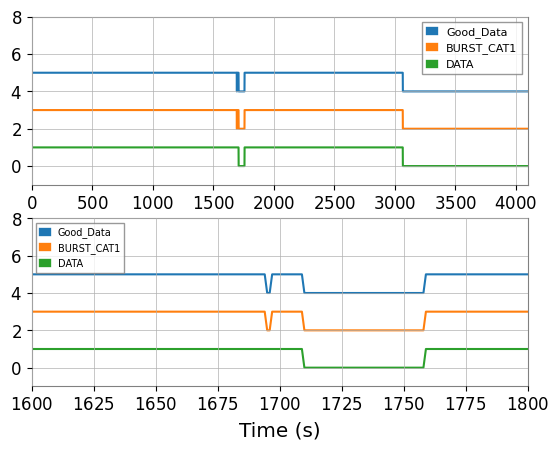

In [30]:
plt.subplot(2, 1, 1)
plt.plot(goodData_1hz + 4, label='Good_Data')
plt.plot(burst1 + 2, label='BURST_CAT1')
plt.plot(sci, label='DATA')
plt.axis([0, 4096, -1, 8])
plt.legend(loc=1, fontsize="8")
#plt.xticks(fontsize=10)

plt.subplot(2, 1, 2)
plt.plot(goodData_1hz + 4, label='Good_Data')
plt.plot(burst1 + 2, label='BURST_CAT1')
plt.plot(sci, label='DATA')
plt.axis([1600, 1800, -1, 8])
plt.legend(loc=2,fontsize="7")
plt.xlabel('Time (s)')

Here are some things to notice in the plot:

*  The channels are off-set vertically so they can all be seen - each channel is either 0 or 1 at any time. 
*  A 1 means the category is passed, and so that second of data is good to use in your analysis.
*  In this example, the "Good_Data" flag is the logical AND of the other two.
*  The BURST_CAT1 flag is 0 for a short time around 1600 s into the file. You may need to zoom in on your plot to see this. So, there are 3 segments of "good data" in this file. 

A convienient way to ignore periods of bad data is to use data quality segments in the form of a list of Python slices. These can be obtained like this: 

Using data directory . ...
Loading ./H-H1_LOSC_4_V1-815411200-4096.hdf5
815411200 815412895
Using data directory . ...
Loading ./H-H1_LOSC_4_V1-815411200-4096.hdf5
815412897 815412910
Using data directory . ...
Loading ./H-H1_LOSC_4_V1-815411200-4096.hdf5
815412959 815414266


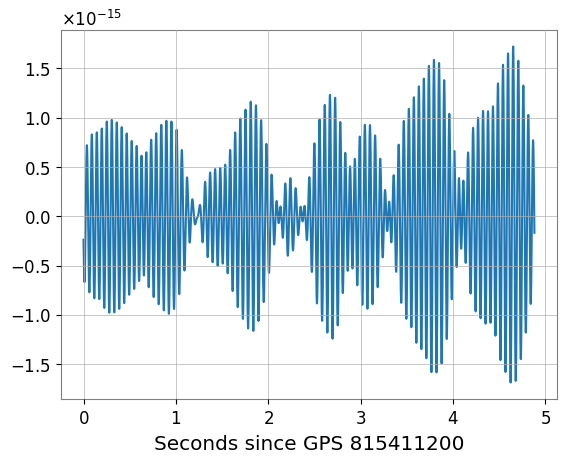

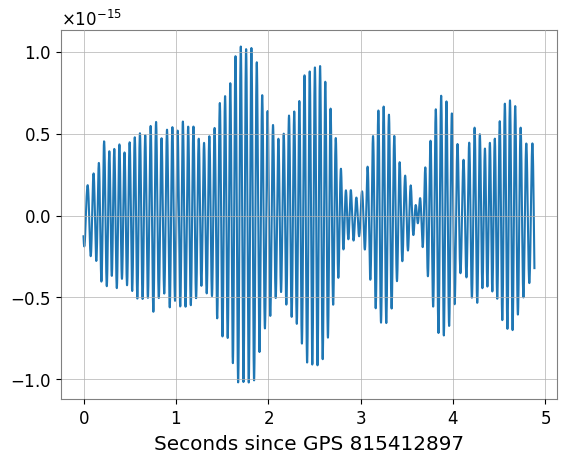

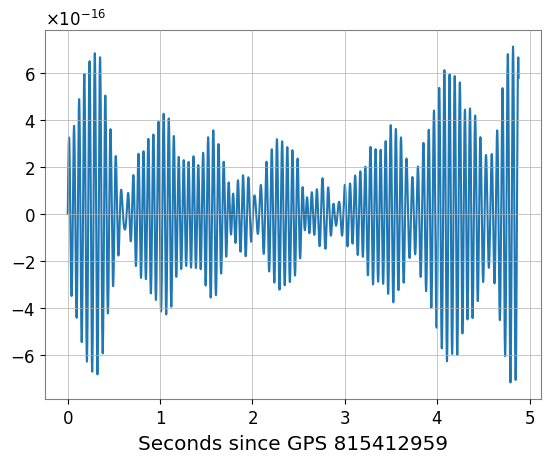

In [31]:
dummy = np.zeros(goodData_1hz.shape)
masked_dummy = np.ma.masked_array(dummy, np.logical_not(goodData_1hz) )
segments = np.ma.flatnotmasked_contiguous(masked_dummy)
segList = [(int(seg.start+gpsStart), int(seg.stop+gpsStart)) for seg in segments]

for (begin, end) in segList:
    # -- Use the getstrain() method to load the data
    strain, meta, dq = rl.getstrain(begin, end, 'H1')
    print(begin,end)

    N=20000
    # -- Make a plot
    plt.figure()
    ts = meta['dt']
    rel_time = np.arange(0, end-begin, meta['dt'])
    plt.plot(rel_time[0:N], strain[0:N])
    plt.xlabel('Seconds since GPS ' + str(begin) )
plt.show()


## Querying for the knwon (GWTC) event information

The module `gwosc.datasets` provides tools for searching for datasets, including events, catalogs and full run strain data releases.


For example, we can search for events in the [GWTC-1 catalog](https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/), the catalog of all events from the O1 and O2 observing runs. A list of available catalogs can be seen in the [Event Portal](https://gw-openscience.org/eventapi)

In [32]:
# -- Uncomment following line if running in Google Colab
! pip install -q 'gwosc==0.5.4'
#print(gwosc.__version__)

from gwosc.datasets import find_datasets
from gwosc import datasets

#-- List all available catalogs
print("List of available catalogs")
print(find_datasets(type="catalog"))
print("")

#-- Print all the GW events from the GWTC-1 catalog
gwtc1 = datasets.find_datasets(type='events', catalog='GWTC-1-confident')
print('GWTC-1 events:', gwtc1)
print("")

Reason for being yanked: Metadata is broken
List of available catalogs
['GWTC', 'GWTC-1-confident', 'GWTC-1-marginal', 'GWTC-2', 'GWTC-2.1-auxiliary', 'GWTC-2.1-confident', 'GWTC-2.1-marginal', 'GWTC-3-confident', 'GWTC-3-marginal', 'Initial_LIGO_Virgo', 'O1_O2-Preliminary', 'O3_Discovery_Papers', 'O3_IMBH_marginal']

GWTC-1 events: ['GW150914-v3', 'GW151012-v3', 'GW151226-v2', 'GW170104-v2', 'GW170608-v3', 'GW170729-v1', 'GW170809-v1', 'GW170814-v3', 'GW170817-v3', 'GW170818-v1', 'GW170823-v1']



Note that the event name is of the type _GWyymmdd-vx_ where _x_ is the last available version for the data set provided by GWOSC.

In [33]:
#-- Print all the large strain data sets from LIGO/Virgo observing runs
runs = find_datasets(type='run')
print('Large data sets:', runs)

Large data sets: ['BKGW170608_16KHZ_R1', 'O1', 'O1_16KHZ', 'O2_16KHZ_R1', 'O2_4KHZ_R1', 'O3GK_16KHZ_R1', 'O3GK_4KHZ_R1', 'O3a_16KHZ_R1', 'O3a_4KHZ_R1', 'O3b_16KHZ_R1', 'O3b_4KHZ_R1', 'S5', 'S6']


_Attention: Note that the most recent observation runs, e.g. O2, are labeled with names containing the name of the run (e.g. O2), the sampling rate (4 or 16 kHz) and the release version (e.g. R1). This means that for O2 you have two labels 'O2_4KHZ_R1' and 'O2_16KHZ_R1', depending which is the desired sampling rate_

`datasets.find_datasets` also accepts a `segment` and `detector` keyword to narrow results based on GPS time and detector:

In [34]:
#-- Detector and segments keywords limit search result
print(datasets.find_datasets(type='events', catalog='GWTC-1-confident', detector="L1", segment=(1164556817, 1187733618)))

['GW170104-v2', 'GW170608-v3', 'GW170729-v1', 'GW170809-v1', 'GW170814-v3', 'GW170817-v3', 'GW170818-v1', 'GW170823-v1']


Using `gwosc.datasets.event_gps`, we can query for the GPS time of a specific event (it works also without the version number):

In [35]:
from gwosc.datasets import event_gps
gps = event_gps('GW190425')
print(gps)

1240215503.0


<div class="alert alert-info">All of these times are returned in the GPS time system, which counts the number of seconds that have elapsed since the start of the GPS epoch at midnight (00:00) on January 6th 1980. GWOSC provides a <a href="https://www.gw-openscience.org/gps/">GPS time converter</a> you can use to translate into datetime, or you can use <a href="https://gwpy.github.io/docs/stable/time/"><code>gwpy.time</code></a>.</div>

We can query for the GPS time interval for an observing run:

In [36]:
from gwosc.datasets import run_segment
print(run_segment('O1'))

(1126051217, 1137254417)


To see only the confident events in O1:

In [37]:
O1_events = datasets.find_datasets(type='events', catalog='GWTC-1-confident', segment=run_segment('O1'))
print(O1_events)

['GW150914-v3', 'GW151012-v3', 'GW151226-v2']


## Querying for data files

The `gwosc.locate` module provides a function to find the URLs of data files associated with a given dataset.

For event datasets, one can get the list of URLs using only the event name:

In [38]:
from gwosc.locate import get_event_urls
urls = get_event_urls('GW150914')
print(urls)

['https://gwosc.org/eventapi/json/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5', 'https://gwosc.org/eventapi/json/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5', 'https://gwosc.org/eventapi/json/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5', 'https://gwosc.org/eventapi/json/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5']


By default, this function returns all of the files associated with a given event, which isn't particularly helpful. However, we can filter on any of these by using keyword arguments, for example to get the URL for the 32-second file for the LIGO-Livingston detector:

In [39]:
urls = get_event_urls('GW150914', duration=32, detector='L1')
print(urls)

['https://gwosc.org/eventapi/json/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5']
